# Wrangle Exercises

 <tr>
    <td> <img src="todd-kent-178j8tJrNlc-unsplash.jpg"/> </td>
    <td> <img src="scott-webb-1ddol8rgUH8-unsplash.jpg"/> </td>
    </tr>

[Source Photo 1](https://unsplash.com/photos/aren8nutd1Q) 
[Source Photo 2](https://unsplash.com/photos/1ddol8rgUH8)

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

## Import Libraries

First we will import the necessary libraries.

In [73]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for dealing with NA values
from sklearn.impute import SimpleImputer

## Acquire data

Acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the `zillow` database for all 'Single Family Residential' properties.

### Connect to SQL server

The following function allows us to use our `env.py` file to connect to the SQL database.

In [74]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
     We establish a connection to the SQL database, using my information stored in the env file.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

### Acquire the data

The following function acquires data from the SQL server and puts that data into a pandas DataFrame.

In [75]:
def get_zillow_data():
    '''
    We will read a SQL query and create a file based on this query. I have also included a line to eliminate duplicate columns because value_counts() does not work if there are duplicate columns in the DataFrame.
    '''
    filename = "zillow.csv"
    ##We will write a SQL query to obtain the data
    sql = ''' 
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
         taxvaluedollarcnt, yearbuilt, taxamount, fips from properties_2017
    JOIN propertylandusetype
    ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
    AND propertylandusetype.propertylandusetypeid = 261 
    '''
    ##If the file already exists we will simply pull the file.
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_sql(sql, get_connection('zillow'))
        return df

Now we will run the function defined above.

In [76]:
df = get_zillow_data()

### Sample and Summarize data

We will look at the DataFrame we just created.

In [77]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


We will display the shape of the data.

In [78]:
df.shape

(2152863, 7)

We will now display summary statistics for our DataFrame.

In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


We will get the DataFrame's info.

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


All of our columns have the datatype `float64`.

### Acquire and Summarize 
 - Our DataFrame has 2,152,863 rows and 7 columns.
 - All of our columns are in the `float64` datatype.

## Prepare the Data

### Finding Null Values

We will find the total number of null values for each column in our DataFrame.

In [81]:
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

All of our columns except for `fips` has null values. There are so many null values, simply dropping the null values will damage our analysis. For example, we cannot simply drop 9,337 columns from the `yearbuilt` column. Thus, we will need to find a way to replace the null values in these columns.

### Impute Null Values

We will use the imputation transformer to fill the missing values in our DataFrame. We will take the mean of each column to replace the missing values.

In [82]:
#We will use the mean imputer function.
imputer = SimpleImputer(strategy='mean')

#We will create a for loop that will impute all the null values in each one of our columns.
for col in df.columns:
    df[[col]] = imputer.fit_transform(df[[col]])

#Now we will check the amount of null values in each column.
df.isnull().sum()      

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

### Eliminate Outliers

The following function will remove outliers from our DataFrame. We can choose a `k` value. The higher the `k` value, we choose, the more outliers we keep.

In [83]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [84]:
df = remove_outliers(df, 3, df.columns)

We have replaced every null value in the DataFrame. Our DataFrame is now ready for us to explore.

## Visualize Distributions

We will plot the data to see the distributions of single variables and check for skewness, outliers, and unit scales. 

Since we are exploring single variables, we do not need to split our data.

### Bedroom Count Distribution

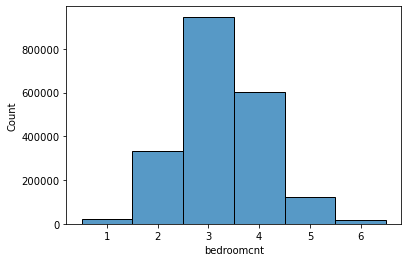

In [85]:
bedroom_count = sns.histplot(data=df, x="bedroomcnt", discrete = True)

### Bathroom Count Distribution

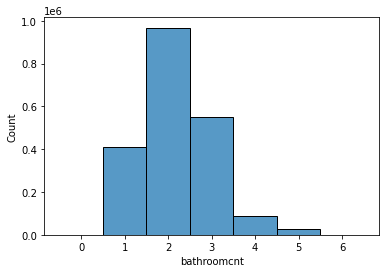

In [86]:
bathroom_count = sns.histplot(data=df, x="bathroomcnt", discrete = True)

### Square feet distribution

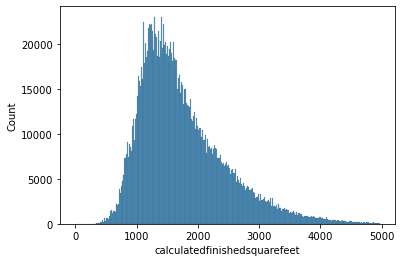

In [87]:
square_feet_log_scale = sns.histplot(data=df, x="calculatedfinishedsquarefeet")

### Tax value distribution

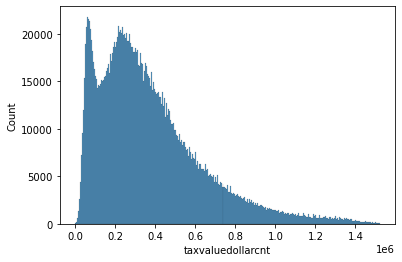

In [88]:
tax_value = sns.histplot(data = df, x = "taxvaluedollarcnt")

### Year built distribution

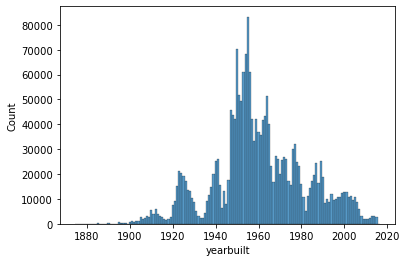

In [89]:
yearbuilt_graph = sns.histplot(data=df, x="yearbuilt", discrete = True)

### Fips distribution

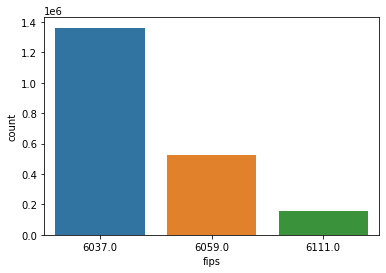

In [90]:
fips_graph = sns.countplot(data =df, x ="fips")

![title](vu-anh-TiVPTYCG_3E-unsplash.jpg)

[Source Photo 3](https://unsplash.com/photos/TiVPTYCG_3E)